# conductive.ai Take-home assignment

## Description:
A semiconductor fab is performing a SATEOS CVD process on 4 different AMAT PRODUCER SE tools.

They have performed Design of Experiments on 500 300mm wafers by varying 3 process parameters:

- Flowfactor: inversely proportional to TEOS (precursor) flow. Actual flow value not accessible at the moment.
- Spacing: distance between shower head and wafer.
- Deposition Time.

Temperature was held constant at 480 celsius. The fab wants to know how would film thickness change if they would change the temperature in the range of 460-500 celsius.

They chose 125 parameter combinations (recipes) and performed each of them on 4 different tools to account for tool variation.

Film thickness values were measured (in angstrom) at 49 specific points on the wafer (sites). The spec is 1500Å.

Coordinates of the sites are given in a separate file. Values are in micrometers, (0,0) is the center of the wafer.

### Task:
 - Reconstruct wafer profile images from sites using interpolation.
 - Build a generative machine learning model (VAE, GAN, or similar) that predicts the thickness profile of the wafer based on flowfactor, spacing, deposition time, and tool.
 - Ensure that the machine learning model is capable of extrapolating 1 standard deviation outside of the ranges of parameters in accordance with physics.

- (Bonus) Build a physics-based model (preferably using simulations) for this process that would include temperature. If you need information on other process parameters, we'd be happy to provide them if available. Adapt it to fit the data. Combine it with the ML model to incorporate the influence of temperature.

In [1]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, LeakyReLU, ReLU, Flatten, Dropout, Dense, Reshape, Conv2DTranspose, BatchNormalization
from tensorflow.keras.optimizers import Adam, Adadelta
from tensorflow.keras.layers import Input, Embedding, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import Mean
import tensorflow as tf
# from tensorflow import InteractiveSession
from tensorflow.keras.models import load_model

import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.pyplot import figure, imshow, axis
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas

from sklearn.preprocessing import MinMaxScaler
from sklearn.manifold import TSNE

import pandas as pd
import numpy as np


In [2]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


Reading the data:

In [3]:
df = pd.read_csv('aug_df.csv',)
df.drop('Unnamed: 0', axis=1, inplace=True)

In [4]:
df

,FLOWFACTOR,SPACING,DEP TIME,TOOL,SITE_0,SITE_1,SITE_2,SITE_3,SITE_4,SITE_5,...,SITE_39,SITE_40,SITE_41,SITE_42,SITE_43,SITE_44,SITE_45,SITE_46,SITE_47,SITE_48
0,0.916000,0.344000,69.289000,1,1601.802686,1556.668725,1597.900238,1599.790647,1601.083756,1601.116007,...,1593.296029,1592.948758,1592.601486,1592.254216,1591.906946,1591.559675,1591.212405,1590.865134,1590.517862,1590.170593
1,0.916000,0.344000,69.289000,2,1516.411140,1495.080373,1516.482818,1516.366352,1516.918855,1514.835611,...,1481.353478,1481.157584,1480.961690,1480.765797,1480.906328,1481.052943,1480.847698,1480.888354,1481.306459,1481.724561
2,0.916000,0.344000,69.289000,3,1478.098433,1457.372553,1483.945610,1481.342541,1475.516841,1472.935249,...,1491.287428,1490.630367,1489.973305,1489.130805,1487.315196,1485.659583,1484.266940,1482.874286,1481.481632,1480.088988
3,0.916000,0.344000,69.289000,4,1550.290615,1529.621080,1548.352252,1549.929704,1549.697136,1549.235110,...,1508.932376,1508.732902,1508.347436,1508.052235,1508.214925,1508.596579,1509.101775,1509.606975,1510.373006,1511.108004
4,0.957000,0.348000,70.253000,1,1544.883218,1495.156181,1549.023309,1547.829132,1544.253208,1543.623198,...,1569.233533,1569.257056,1569.280579,1569.252501,1568.966865,1568.681228,1568.395593,1567.875699,1567.033903,1565.635512
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15495,0.937361,0.351846,68.588251,4,1418.944207,1395.905787,1417.039855,1418.314258,1418.548356,1418.190233,...,1386.946634,1387.820508,1388.694383,1389.568251,1389.731766,1389.559373,1389.297439,1388.139341,1387.565291,1386.798290
15496,0.915323,0.356683,65.979628,4,1418.944207,1395.905787,1417.039855,1418.314258,1418.548356,1418.190233,...,1386.946634,1387.820508,1388.694383,1389.568251,1389.731766,1389.559373,1389.297439,1388.139341,1387.565291,1386.798290
15497,0.940214,0.358864,68.418927,4,1418.944207,1395.905787,1417.039855,1418.314258,1418.548356,1418.190233,...,1386.946634,1387.820508,1388.694383,1389.568251,1389.731766,1389.559373,1389.297439,1388.139341,1387.565291,1386.798290
15498,0.958711,0.349009,68.973925,4,1418.944207,1395.905787,1417.039855,1418.314258,1418.548356,1418.190233,...,1386.946634,1387.820508,1388.694383,1389.568251,1389.731766,1389.559373,1389.297439,1388.139341,1387.565291,1386.798290


In [5]:
features = ['FLOWFACTOR', 'SPACING', 'DEP TIME', 'TOOL']
all_sites = df.columns.drop(features)

### Defining weights of the samples:

In [6]:
Y_COLUMNS = ['FLOWFACTOR', 'SPACING', 'DEP TIME']
scaler_y = MinMaxScaler()

y = df[Y_COLUMNS]
y_scaled = scaler_y.fit_transform(y)

tsne=TSNE()
y_tsne = tsne.fit_transform(y_scaled)

FLOWFACTOR


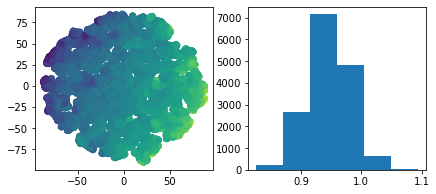

SPACING


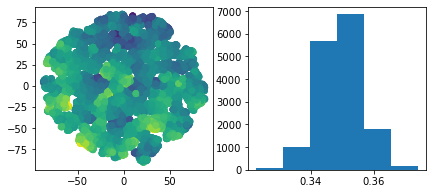

DEP TIME


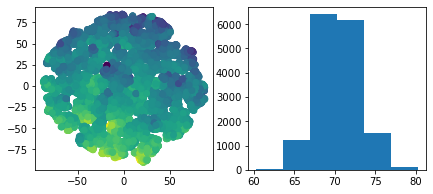

In [7]:
#number of bins per each extrinsic properties
BINS=6

for Y_column in Y_COLUMNS:
    print(Y_column)
    fig, axs= plt.subplots(1,2, figsize=(7,3))
    im=axs[0].scatter(y_tsne[:,0], y_tsne[:,1], c= df[Y_column]);
    h=axs[1].hist(df[Y_column], bins=BINS)
    plt.show()

binning_labels_dict={}
binning_labels_dict['TOOL_binning'] = df['TOOL'].values

Y_COLUMNS_BINNING=['TOOL_binning']
for Y_column in Y_COLUMNS:
    cnt, bins = np.histogram(df[Y_column], bins=BINS)
    bins[0] -= 1
    col_name = Y_column + "_binning"
    binning_labels_dict[col_name] = np.searchsorted(bins, df[Y_column].values)
    Y_COLUMNS_BINNING.append(col_name)
    

In [8]:
binning_df = pd.DataFrame(binning_labels_dict)#.groupby(col_name).count()
binning_df["T"] = 1
count_bins_df = binning_df.groupby(Y_COLUMNS_BINNING).count()
max_count = count_bins_df["T"].max()

df = pd.concat((df,binning_df),axis=1)
df = df.drop("T",axis=1)
count_bins_df = count_bins_df.reset_index()
df = pd.merge(df,count_bins_df,on=Y_COLUMNS_BINNING)
df["weight"] = max_count/df["T"]

## One-hot encoding of TOOL feature:

In [9]:
df = pd.get_dummies(df, columns=['TOOL'] )

In [10]:
df

,FLOWFACTOR,SPACING,DEP TIME,SITE_0,SITE_1,SITE_2,SITE_3,SITE_4,SITE_5,SITE_6,...,TOOL_binning,FLOWFACTOR_binning,SPACING_binning,DEP TIME_binning,T,weight,TOOL_1,TOOL_2,TOOL_3,TOOL_4
0,0.916000,0.344000,69.289000,1601.802686,1556.668725,1597.900238,1599.790647,1601.083756,1601.116007,1592.004563,...,1,3,3,3,275,1.250909,1,0,0,0
1,0.957000,0.348000,70.253000,1544.883218,1495.156181,1549.023309,1547.829132,1544.253208,1543.623198,1546.111113,...,1,3,3,3,275,1.250909,1,0,0,0
2,0.958000,0.346000,67.731000,1510.842000,1455.549246,1509.432032,1509.452372,1511.438728,1508.850282,1511.903577,...,1,3,3,3,275,1.250909,1,0,0,0
3,0.950000,0.348000,68.717000,1533.913997,1481.479202,1536.954075,1535.947508,1533.079325,1529.687276,1533.721641,...,1,3,3,3,275,1.250909,1,0,0,0
4,0.930000,0.341000,69.937000,1603.464336,1557.612908,1597.991506,1601.100224,1605.828448,1607.399440,1588.552981,...,1,3,3,3,275,1.250909,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15495,0.988023,0.350516,63.055042,1458.274911,1421.623454,1462.182249,1460.786941,1458.125382,1455.511046,1459.721135,...,3,4,4,1,1,344.000000,0,0,1,0
15496,1.007369,0.366841,70.487549,1524.357593,1467.671002,1520.614328,1522.485960,1525.946379,1526.543912,1520.740307,...,1,5,6,4,1,344.000000,1,0,0,0
15497,1.009791,0.367678,71.842340,1471.863636,1464.154581,1478.365685,1473.964820,1469.762452,1468.278477,1489.212555,...,3,5,6,4,1,344.000000,0,0,1,0
15498,0.934042,0.360590,60.306143,1418.944207,1395.905787,1417.039855,1418.314258,1418.548356,1418.190233,1422.494546,...,4,3,5,1,1,344.000000,0,0,0,1


In [11]:
Y_COLUMNS = ['FLOWFACTOR', 'SPACING', 'DEP TIME', 'TOOL_1', 'TOOL_2', 'TOOL_3', 'TOOL_4']

In [12]:
df

,FLOWFACTOR,SPACING,DEP TIME,SITE_0,SITE_1,SITE_2,SITE_3,SITE_4,SITE_5,SITE_6,...,TOOL_binning,FLOWFACTOR_binning,SPACING_binning,DEP TIME_binning,T,weight,TOOL_1,TOOL_2,TOOL_3,TOOL_4
0,0.916000,0.344000,69.289000,1601.802686,1556.668725,1597.900238,1599.790647,1601.083756,1601.116007,1592.004563,...,1,3,3,3,275,1.250909,1,0,0,0
1,0.957000,0.348000,70.253000,1544.883218,1495.156181,1549.023309,1547.829132,1544.253208,1543.623198,1546.111113,...,1,3,3,3,275,1.250909,1,0,0,0
2,0.958000,0.346000,67.731000,1510.842000,1455.549246,1509.432032,1509.452372,1511.438728,1508.850282,1511.903577,...,1,3,3,3,275,1.250909,1,0,0,0
3,0.950000,0.348000,68.717000,1533.913997,1481.479202,1536.954075,1535.947508,1533.079325,1529.687276,1533.721641,...,1,3,3,3,275,1.250909,1,0,0,0
4,0.930000,0.341000,69.937000,1603.464336,1557.612908,1597.991506,1601.100224,1605.828448,1607.399440,1588.552981,...,1,3,3,3,275,1.250909,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15495,0.988023,0.350516,63.055042,1458.274911,1421.623454,1462.182249,1460.786941,1458.125382,1455.511046,1459.721135,...,3,4,4,1,1,344.000000,0,0,1,0
15496,1.007369,0.366841,70.487549,1524.357593,1467.671002,1520.614328,1522.485960,1525.946379,1526.543912,1520.740307,...,1,5,6,4,1,344.000000,1,0,0,0
15497,1.009791,0.367678,71.842340,1471.863636,1464.154581,1478.365685,1473.964820,1469.762452,1468.278477,1489.212555,...,3,5,6,4,1,344.000000,0,0,1,0
15498,0.934042,0.360590,60.306143,1418.944207,1395.905787,1417.039855,1418.314258,1418.548356,1418.190233,1422.494546,...,4,3,5,1,1,344.000000,0,0,0,1


## Data preproccesing and rescaling for the model

The thickness profile array with the shape of (49,) reshaped to a 7x7 matrix for the convolutional networks

In [13]:
BATCH_SIZE=16
batch_count = int(np.ceil(len(df)/BATCH_SIZE))

WEIGHTS=[]

# reshape the thickness array to 7x7 matrix and rescale
scaler_x = MinMaxScaler((-1,1))
XS_scaled = scaler_x.fit_transform(df[all_sites])
XS_scaled = XS_scaled.reshape(15500, 7, 7)

scaler_y_2 = MinMaxScaler()
YS = df[Y_COLUMNS] #for testing the model only
YS_scaled = scaler_y_2.fit_transform(df[Y_COLUMNS])

for b in range(0, batch_count):
    print(b * BATCH_SIZE,"->",min(len(df), b * BATCH_SIZE+BATCH_SIZE) - 1)
    batch_indices = np.arange(b * BATCH_SIZE, min(len(df), b * BATCH_SIZE + BATCH_SIZE))
    for ind in batch_indices:              
         WEIGHTS.append(df.loc[ind,"weight"])
        

WEIGHTS = np.array(WEIGHTS)
dataset=(XS_scaled, YS_scaled, WEIGHTS)

0 -> 15
16 -> 31
32 -> 47
48 -> 63
64 -> 79
80 -> 95
96 -> 111
112 -> 127
128 -> 143
144 -> 159
160 -> 175
176 -> 191
192 -> 207
208 -> 223
224 -> 239
240 -> 255
256 -> 271
272 -> 287
288 -> 303
304 -> 319
320 -> 335
336 -> 351
352 -> 367
368 -> 383
384 -> 399
400 -> 415
416 -> 431
432 -> 447
448 -> 463
464 -> 479
480 -> 495
496 -> 511
512 -> 527
528 -> 543
544 -> 559
560 -> 575
576 -> 591
592 -> 607
608 -> 623
624 -> 639
640 -> 655
656 -> 671
672 -> 687
688 -> 703
704 -> 719
720 -> 735
736 -> 751
752 -> 767
768 -> 783
784 -> 799
800 -> 815
816 -> 831
832 -> 847
848 -> 863
864 -> 879
880 -> 895
896 -> 911
912 -> 927
928 -> 943
944 -> 959
960 -> 975
976 -> 991
992 -> 1007
1008 -> 1023
1024 -> 1039
1040 -> 1055
1056 -> 1071
1072 -> 1087
1088 -> 1103
1104 -> 1119
1120 -> 1135
1136 -> 1151
1152 -> 1167
1168 -> 1183
1184 -> 1199
1200 -> 1215
1216 -> 1231
1232 -> 1247
1248 -> 1263
1264 -> 1279
1280 -> 1295
1296 -> 1311
1312 -> 1327
1328 -> 1343
1344 -> 1359
1360 -> 1375
1376 -> 1391
1392 -> 

12496 -> 12511
12512 -> 12527
12528 -> 12543
12544 -> 12559
12560 -> 12575
12576 -> 12591
12592 -> 12607
12608 -> 12623
12624 -> 12639
12640 -> 12655
12656 -> 12671
12672 -> 12687
12688 -> 12703
12704 -> 12719
12720 -> 12735
12736 -> 12751
12752 -> 12767
12768 -> 12783
12784 -> 12799
12800 -> 12815
12816 -> 12831
12832 -> 12847
12848 -> 12863
12864 -> 12879
12880 -> 12895
12896 -> 12911
12912 -> 12927
12928 -> 12943
12944 -> 12959
12960 -> 12975
12976 -> 12991
12992 -> 13007
13008 -> 13023
13024 -> 13039
13040 -> 13055
13056 -> 13071
13072 -> 13087
13088 -> 13103
13104 -> 13119
13120 -> 13135
13136 -> 13151
13152 -> 13167
13168 -> 13183
13184 -> 13199
13200 -> 13215
13216 -> 13231
13232 -> 13247
13248 -> 13263
13264 -> 13279
13280 -> 13295
13296 -> 13311
13312 -> 13327
13328 -> 13343
13344 -> 13359
13360 -> 13375
13376 -> 13391
13392 -> 13407
13408 -> 13423
13424 -> 13439
13440 -> 13455
13456 -> 13471
13472 -> 13487
13488 -> 13503
13504 -> 13519
13520 -> 13535
13536 -> 13551
13552 -> 1

## Discriminator Model

In [14]:
INPUT_SHAPE=(7, 7, 1)
EXTRINSIC_DIM = 7 #LABELS, Y
latent_dim = 32 # need to confirm
LATENT_DIM = latent_dim

In [15]:
# define the standalone discriminator model
# @tf.function
def define_cond_discriminator(in_shape=INPUT_SHAPE, n_classes=EXTRINSIC_DIM):    
    # label input
    in_label = Input(shape=(EXTRINSIC_DIM,), name="Y_extrinsic")
    # scale up to image dimensions with linear activation
    n_nodes = in_shape[0] * in_shape[1]

    li = Dense(n_nodes)(in_label)

    # reshape to additional channel
    li = Reshape((in_shape[0], in_shape[1], 1))(li)

    # image input
    in_image = Input(shape=in_shape, name="X")
    # concat label as a channel
    merge = Concatenate()([in_image, li])
    # downsample
    fe = Conv2D(128, (3,3), strides=(2,2), padding='same')(merge)
#     fe = BatchNormalization()(fe)
    fe = LeakyReLU(alpha=0.2)(fe)
#     fe = Dropout(0.3)(fe)
    # downsample
    fe = Conv2D(128, (3,3), strides=(2,2), padding='same')(fe)
    fe = LeakyReLU(alpha=0.2)(fe)
#     fe = BatchNormalization()(fe)
    # flatten feature maps
    fe = Flatten()(fe)
    # dropout
    fe = Dropout(0.4)(fe)
    # output
    out_layer = Dense(1, activation='sigmoid',name="Discriminator")(fe)
    # define model
    model = Model([in_image, in_label], out_layer)
    # compile model
    opt = Adam(lr=0.00001, beta_1=0.5)
    #opt = Adadelta()

    model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
    return model

In [16]:
discriminator_model = define_cond_discriminator()

In [17]:
discriminator_model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Y_extrinsic (InputLayer)        [(None, 7)]          0                                            
__________________________________________________________________________________________________
dense (Dense)                   (None, 49)           392         Y_extrinsic[0][0]                
__________________________________________________________________________________________________
X (InputLayer)                  [(None, 7, 7, 1)]    0                                            
__________________________________________________________________________________________________
reshape (Reshape)               (None, 7, 7, 1)      0           dense[0][0]                      
_______________________________________________________________________________________

## Generator Model

In [18]:

# define the standalone generator model
def define_cond_generator(latent_dim=LATENT_DIM, n_classes=EXTRINSIC_DIM):
    init_size=(7, 7)

    # label input
    in_label = Input(shape=(EXTRINSIC_DIM,), name="Y_extrinsic")
    # linear multiplication
    n_nodes = init_size[0] * init_size[1]
    li = Dense(n_nodes)(in_label)
#     li = BatchNormalization()(li)
#     li = Dropout(0.3)(li)

    # reshape to additional channel
    li = Reshape((init_size[0] , init_size[1], 1))(li)

    # image generator input
    in_lat = Input(shape=(latent_dim,), name="Z_latent")
    # foundation for 7x7 image
    n_nodes = 128 * n_nodes
    gen = Dense(n_nodes)(in_lat)
    gen = LeakyReLU(alpha=0.2)(gen)
#     gen = BatchNormalization()(gen)
#     gen = Dropout(0.5)(gen)
    
    gen = Reshape((init_size[0], init_size[1], 128))(gen)

    # merge image gen and label input
    merge = Concatenate()([gen, li])
   
#     gen = Conv2DTranspose(128, (3,3), strides=(2,2), padding='same')(merge)
#     gen = LeakyReLU(alpha=0.2)(gen)
#     gen = BatchNormalization()(gen)
#     gen = Dropout(0.2)(gen)

#     gen = Conv2DTranspose(128, (3,3), strides=(2,2), padding='same')(gen)
#     gen = LeakyReLU(alpha=0.2)(gen)
#     gen = BatchNormalization()(gen)
#     gen = Dropout(0.2)(gen)
    
#     gen = Conv2D(128, (3,3), strides=(2,2), padding='same')(gen)
#     gen = BatchNormalization()(gen)
#     gen = LeakyReLU(alpha=0.2)(gen)
# #     fe = Dropout(0.3)(fe)
#     # downsample
#     gen = Conv2D(128, (3,3), strides=(2,2), padding='same')(gen)
#     gen = LeakyReLU(alpha=0.2)(gen)
#     gen = BatchNormalization()(gen)
    
#     gen = Reshape((5, 10, 1))(gen)

    # output
    out_layer = Conv2D(1, (2, 2),activation='tanh', padding='same', name="X_generated")(merge)

    # define model
    model = Model([in_lat, in_label], out_layer)
    return model

In [19]:
generator_model = define_cond_generator()

    

In [20]:
generator_model.summary()

Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Z_latent (InputLayer)           [(None, 32)]         0                                            
__________________________________________________________________________________________________
dense_2 (Dense)                 (None, 6272)         206976      Z_latent[0][0]                   
__________________________________________________________________________________________________
Y_extrinsic (InputLayer)        [(None, 7)]          0                                            
__________________________________________________________________________________________________
leaky_re_lu_2 (LeakyReLU)       (None, 6272)         0           dense_2[0][0]                    
_______________________________________________________________________________________

## Combine generator and discriminator model

In [21]:
# define the combined generator and discriminator model, for updating the generator
def define_cond_gan(g_model, d_model):
    # make weights in the discriminator not trainable
    d_model.trainable = False
    # get noise and label inputs from generator model
    gen_noise, gen_label = g_model.input
    # get image output from the generator model
    gen_output = g_model.output
    # connect image output and label input from generator as inputs to discriminator
    gan_output = d_model([gen_output, gen_label])
    # define gan model as taking noise and label and outputting a classification
    model = Model([gen_noise, gen_label], gan_output)
    # compile model
    opt = Adam(lr=0.00001, beta_1=0.5)
    model.compile(loss='binary_crossentropy', optimizer=opt)
    return model

In [22]:
GAN = define_cond_gan(generator_model, discriminator_model)

# Generate Real and Fake Samples:

In [23]:
# select real samples
def generate_real_samples(dataset, n_samples):
    # split into vector and labels
    vector, labels, weights = dataset
    # choose random instances
    ix = np.random.randint(0, vector.shape[0]-1, n_samples) # n_samples were removed I dunno why
    # select vector and labels
    X, labels, weights = vector[ix], labels[ix], weights[ix]
    # generate class labels
    y = np.ones((n_samples, 1))
    return [X, labels], y, weights

In [24]:
# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n_samples, n_classes=EXTRINSIC_DIM):
    # generate points in the latent space
    x_input = np.random.randn(latent_dim * n_samples)
    # reshape into a batch of inputs for the network
    z_input = x_input.reshape(n_samples, latent_dim)
    # generate labels
    labels = np.random.choice(len(YS_scaled), size=n_samples)
    weights = WEIGHTS[labels]
    labels= YS_scaled[labels]    
    return z_input, labels, weights

# use the generator to generate n fake examples, with class labels
def generate_fake_samples(generator, latent_dim, n_samples):
    # generate points in latent space
    z_input, labels_input, weights_input = generate_latent_points(latent_dim, n_samples)
    # predict outputs
    images = generator.predict([z_input, labels_input])
    # create class labels
    y = np.zeros((n_samples, 1))
    return [images, labels_input], y, weights_input

## Trainig the GAN model function:

In [25]:
# function for trainining of generator and discriminator
def train_cgan(g_model, d_model, gan_model, dataset, latent_dim, n_epochs=32, verbose_freq=10, n_batch=32):
    fig,ax = plt.subplots(1,1)
    ax.set_xlabel('Epochs')
    ax.set_ylabel('Loss')
    
    bat_per_epo = int(dataset[0].shape[0] / n_batch)
    half_batch = int(n_batch / 2)

    # manually enumerate epochs
    d_loss1_epochs=[]
    d_loss2_epochs=[]
    g_loss_epochs=[]
    d_loss1_batch=[]
    d_loss2_batch=[]
    g_loss_batch=[]
    
    
    # manually enumerate epochs
    iteration=0
    for i in range(n_epochs):
        # enumerate batches over the training set
        for j in range(bat_per_epo):
            # get randomly selected 'real' samples
            [X_real, labels_real], y_real, weights_real = generate_real_samples(dataset, half_batch)
            # update discriminator model weights
            d_loss1, _ = d_model.train_on_batch([X_real, labels_real], y_real,) # sample_weight=weights_real)
            # generate 'fake' examples
            [X_fake, labels], y_fake, weights_fake = generate_fake_samples(g_model, latent_dim, half_batch)
            # update discriminator model weights
            d_loss2, _ = d_model.train_on_batch([X_fake, labels], y_fake,)#sample_weight=weights_fake)
            # prepare points in latent space as input for the generator
            z_input, labels_input, weights_gan = generate_latent_points(latent_dim, n_batch)
            # create inverted labels for the fake samples
            y_gan = np.ones((n_batch, 1))
            # update the generator via the discriminator's error
            g_loss = gan_model.train_on_batch([z_input, labels_input], y_gan,) #sample_weight=weights_gan)
            
            d_loss1_batch.append(d_loss1)
            d_loss2_batch.append(d_loss2)
            g_loss_batch.append(g_loss)
        

            # visualizing the training steps
            if (iteration%verbose_freq==0):
                if ax.lines:
                    epochs_x = (np.arange(len(d_loss2_batch))+1)/bat_per_epo
                    for line,ydata in zip(ax.lines,[d_loss1_batch, d_loss2_batch,g_loss_batch]):
                        line.set_xdata(epochs_x)
                        line.set_ydata(ydata) 
                    ax.set_xlim(0,max(epochs_x) + 1/bat_per_epo)
                    ax.set_ylim(0.9 * min([min(d_loss1_batch), min(d_loss2_batch), min(g_loss_batch)]), 1.1 * max([max(d_loss1_batch), max(d_loss2_batch), max(g_loss_batch)]))
                else:
                    ax.plot(d_loss1_batch, label="d_loss_real")
                    ax.plot(d_loss2_batch, label="d_loss_fake")
                    ax.plot(g_loss_batch, label="g_loss")                 
                    fig.legend()
                fig.canvas.draw()
                
            iteration += 1
            
    if ax.lines:        
        epochs_x=(np.arange(len(d_loss2_batch))+1)/bat_per_epo
        for line,ydata in zip(ax.lines,[d_loss1_batch, d_loss2_batch,g_loss_batch]):
            line.set_xdata(epochs_x)
            line.set_ydata(ydata) 
        ax.set_xlim(0,max(epochs_x)+1/bat_per_epo)
        ax.set_ylim(0.9*min([min(d_loss1_batch),min(d_loss2_batch),min(g_loss_batch)]),1.1*max([max(d_loss1_batch), max(d_loss2_batch), max(g_loss_batch)]))
    else:
        ax.plot(d_loss1_batch, label="d_loss_real")
        ax.plot(d_loss2_batch, label="d_loss_fake")
        ax.plot(g_loss_batch, label="g_loss")                 
        fig.legend()
    fig.canvas.draw()

### Process vector from the inputs and visualization functions:

In [26]:
def create_process_vector(features):
    features = np.array(features).reshape(1, -1)
    process_vector = scaler_y_2.transform(features)
    return process_vector

In [27]:
import plotly.figure_factory as ff
from scipy.spatial import Delaunay

def visualize(thickness):
    site = pd.read_csv('site_coordinates.csv')
    site['SITE_Z'] = thickness
    points2D = np.vstack([site['SITE_X'], site['SITE_Y']]).T
    tri = Delaunay(points2D)
    simplices = tri.simplices

    fig = ff.create_trisurf(site['SITE_X'], site['SITE_Y'], site['SITE_Z'],
                             simplices=simplices,
                             title="wafare", aspectratio=dict(x=1, y=1, z=0.5))
    fig.show()


In [39]:
def visualize_sample(i):
    pp = create_process_vector(YS[i])
    latent_points, labels, _ = generate_latent_points(latent_dim, 1)
    del labels
    X_test = generator_model.predict([latent_points, pp])
    X_test = scaler_x.inverse_transform(X_test.reshape(1,-1))
    visualize(X_test[0])

### Training:

train model for 1024
0
1937.5


<IPython.core.display.Javascript object>


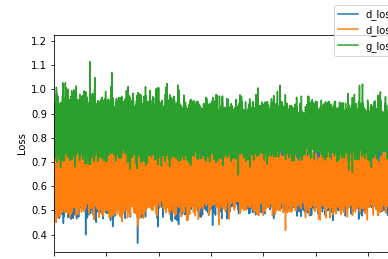

1
3875.0


<IPython.core.display.Javascript object>


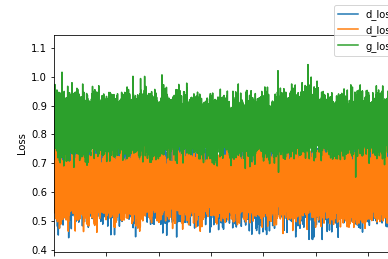

2
5812.5


<IPython.core.display.Javascript object>


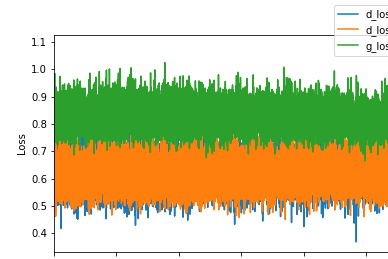

In [ ]:
%matplotlib notebook
# train model
n_runs = 64
total_batch = 0
total_epochs = 0
n_batch = 128
n_epochs = 16

print('train model for ' + str(n_runs * n_epochs))
for k in range(n_runs):
    print(k)
    total_batch = total_batch + (dataset[0].shape[0] / n_batch) * n_epochs
    print(total_batch)
    train_cgan(generator_model, discriminator_model, GAN, dataset, latent_dim)
    
    #visualize samples after each run
    visualize_sample(0)
    visualize_sample(1)
    visualize_sample(3)
    visualize_sample(4)
    

    # save models
    savename = '7x7_aug_data_2'
    generator_model.save(savename+'_total_batches_'+str(total_batch) + '_generator.h5')
    discriminator_model.save(savename+'_total_batches_'+str(total_batch) + ' _discriminator.h5')
    GAN.save(savename+'_total_batches_'+str(total_batch) + '_gan.h5')

In [37]:
latent_points, labels, _ = generate_latent_points(latent_dim, 1)

In [61]:
visualize_sample(4)